In [25]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import math
import seaborn as sns
import CPTAC

In [144]:
### Step 2 getting TP53 mutation status done in a simple df
clinical_full = CPTAC.get_clinical() 
clinical = clinical_full[['Proteomics_Participant_ID', 'Histologic_Grade_FIGO', 'Myometrial_invasion_Specify', 'Histologic_type', 'FIGO_stage']]
clinical.head()
proteomics = CPTAC.get_proteomics()
somatic = CPTAC.get_somatic()
gene = 'TP53' 
protein = 'TP53'

##Identifying Hotspot Patients
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del', 'p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Patient_Id']

df_TP53 = clinical.loc[(clinical['Proteomics_Participant_ID'].isin(hotspot_patients))]

clinical['P53_hotspot'] = 'No'
clinical.loc[clinical['Proteomics_Participant_ID'].isin(hotspot_patients), 'P53_hotspot'] = 'Yes'

loc_compare = CPTAC.compare_mutations(proteomics, protein, gene)

clinical = clinical.join(loc_compare)
tumor_clinical = clinical.loc[clinical['Patient_Type'] == 'Tumor']

clinical_full = clinical_full.join(loc_compare)
clinical_full = clinical_full.loc[clinical_full['Patient_Type'] == 'Tumor']

clinical_full = clinical_full.set_index('Proteomics_Participant_ID')
clinical = clinical.set_index('Proteomics_Participant_ID')

clinical_full['Within_Hotspot'] = False
clinical_full.loc[hotspot_patients, 'Within_Hotspot'] = True

clinical_full.loc[clinical_full['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'WT'

/Users/jonjarman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jonjarman/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/jonjarman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [148]:
BF = 0.05/101

hotspot = clinical_full.loc[clinical_full['Within_Hotspot'] == True]
non_hotspot = clinical_full.loc[clinical_full['Within_Hotspot'] != True]
wildtype = clinical_full.loc[clinical_full['Within_Hotspot'] == 'WT']
TP53_mutation = clinical_full.loc[clinical_full['Within_Hotspot'] != 'WT']


##P53 Hotspot vs. All Mutations
print('HOTSPOT vs. EVERYTHING')
sig_dict1 = {}
sig_list = []
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(hotspot[feature].dropna(axis=0), non_hotspot[feature].dropna(axis = 0))
        TTest += 1
        if ttest[1] <= BF:
            sig_list.append(feature)
            sig_dict1[feature] = ttest[1]
            print(feature)
            print(ttest)
            print('\n')
        
##P53 TP53 Mutation vs. Wildtype
print('TP53 Mutation vs. WILDTYPE')
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(TP53_mutation[feature].dropna(axis=0), wildtype[feature].dropna(axis = 0))
        TTest += 1
        if ttest[1] <= BF:
            if feature in sig_dict1:
                print('***DUPLICATE***')
            else:
                sig_list.append(feature)
            print(feature)
            print(ttest)
            print('\n')




        
    

HOTSPOT vs. EVERYTHING
Pathway_activity_JAK.STAT
Ttest_indResult(statistic=4.630135454670901, pvalue=1.1459321916777611e-05)


Pathway_activity_p53
Ttest_indResult(statistic=-3.6804427342069204, pvalue=0.0003844583430094881)


TP53_TP53
Ttest_indResult(statistic=9.073036977771004, pvalue=1.2427601997591117e-14)


TP53_pathway
Ttest_indResult(statistic=6.323290282756281, pvalue=7.631134263843974e-09)


PI3K_pathway
Ttest_indResult(statistic=-4.601540310411988, pvalue=1.2570312529827001e-05)


Mutation_signature_C>G
Ttest_indResult(statistic=3.6681972621248016, pvalue=0.00039723548501066115)


TP53
Ttest_indResult(statistic=8.854794158768678, pvalue=9.722321381617046e-14)


TP53 Mutation vs. WILDTYPE
LVSI
Ttest_indResult(statistic=4.373790901875431, pvalue=3.100302642560359e-05)


Estrogen_Receptor_%
Ttest_indResult(statistic=-3.856544626291203, pvalue=0.0004717873744776047)


***DUPLICATE***
Pathway_activity_JAK.STAT
Ttest_indResult(statistic=5.414651489765074, pvalue=4.528219552713036e

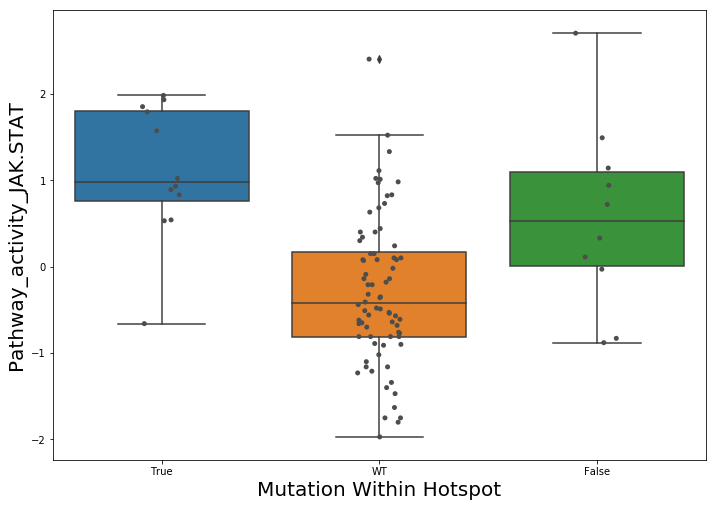

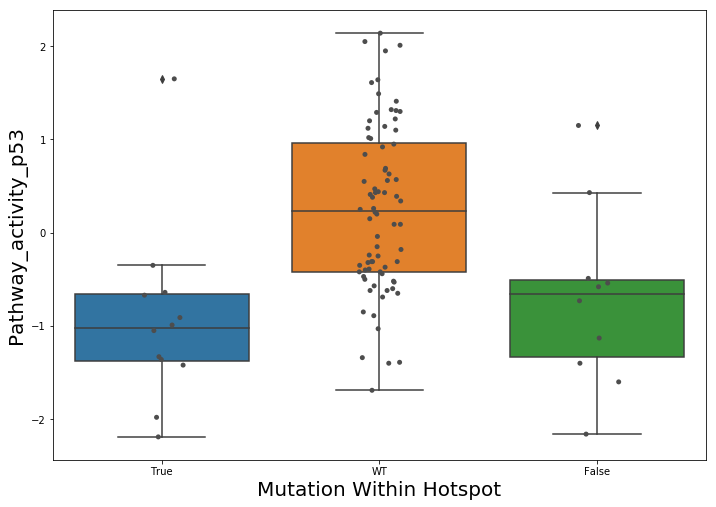

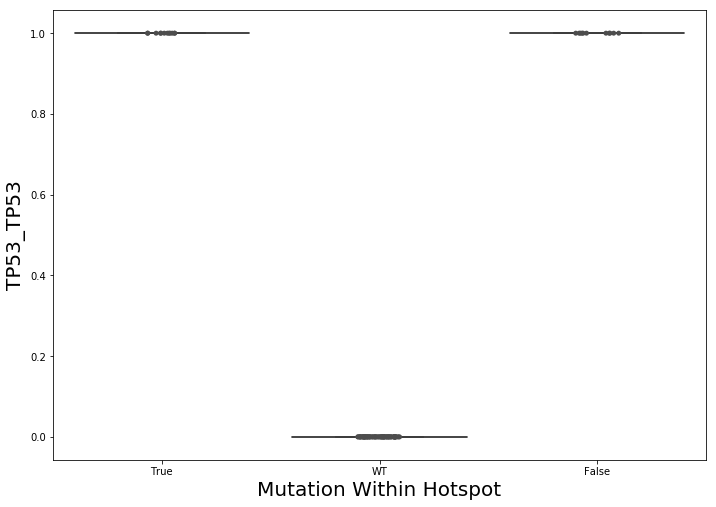

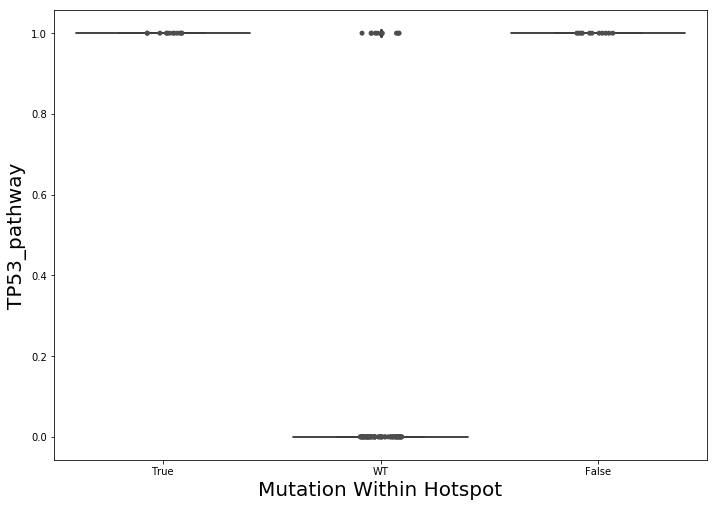

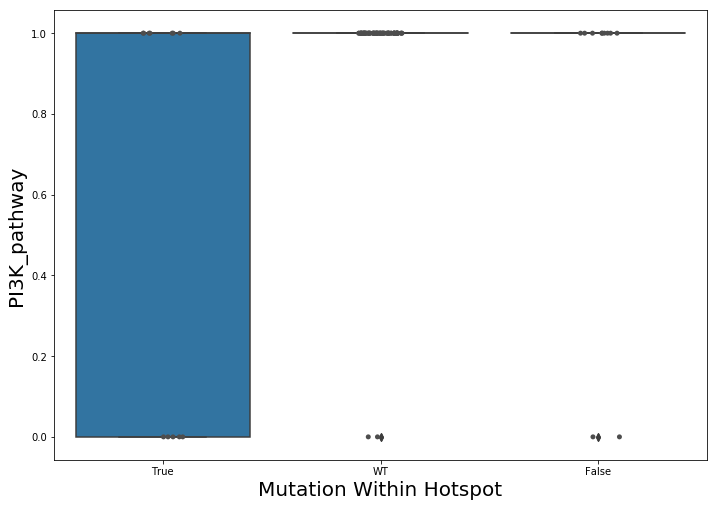

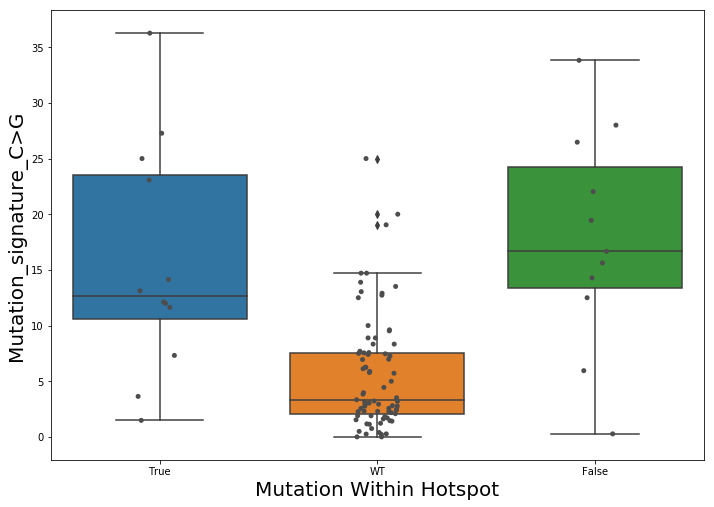

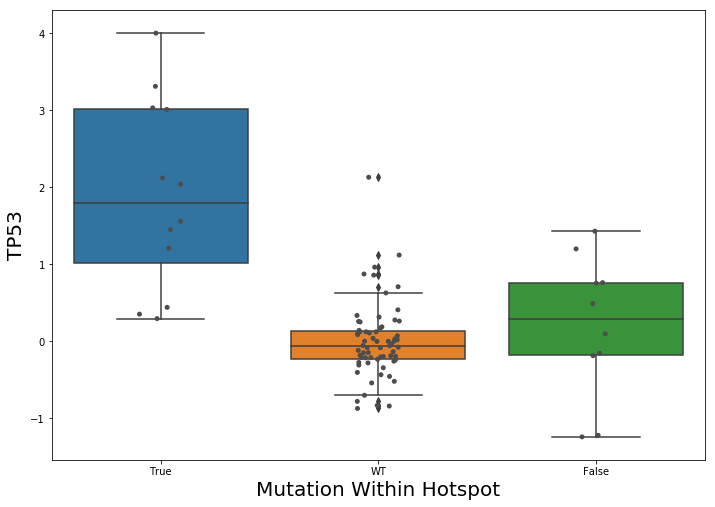

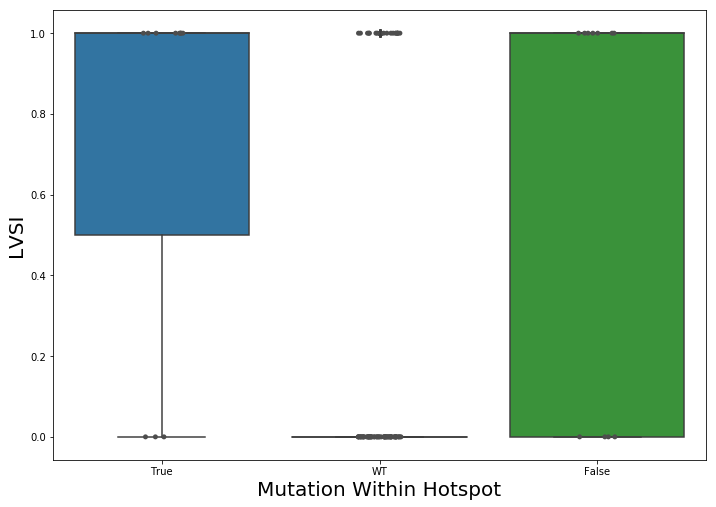

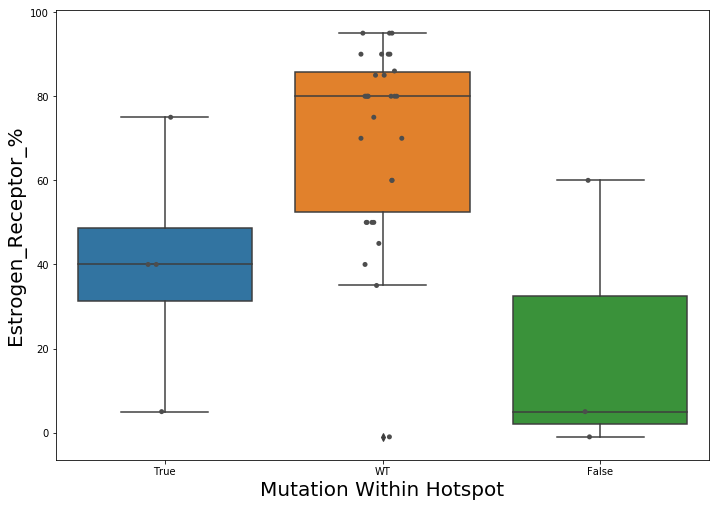

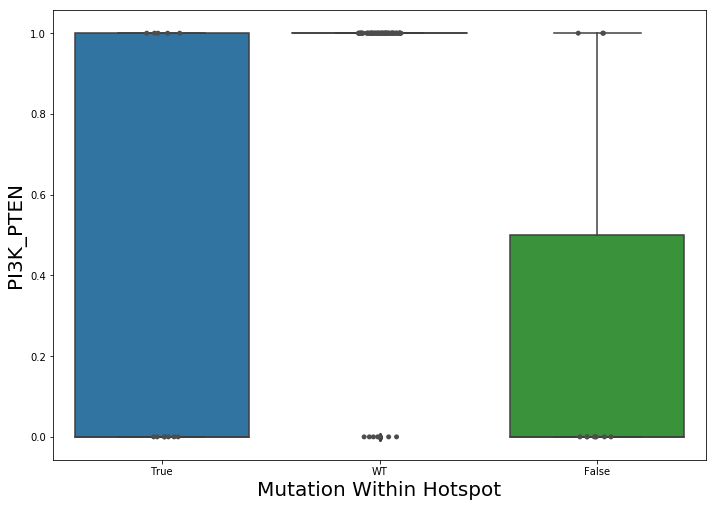

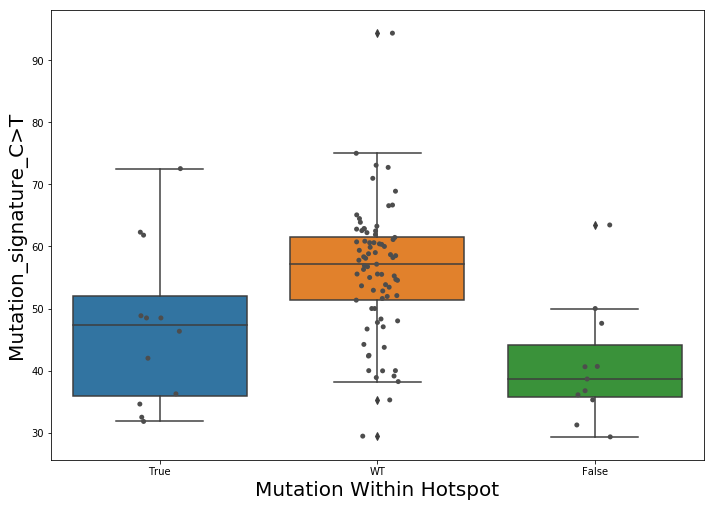

In [152]:
for feature in sig_list:
    Y_var = feature
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize = a4_dims)
    boxplt = sns.boxplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, ax = ax)
    boxplt = sns.stripplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, jitter = True, color = '.3')
    boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
    boxplt.set_ylabel(Y_var, fontsize='20')
    #boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics", fontsize='22')
    plt.show()